In [1]:
%load_ext autoreload
%cd ..
%autoreload 2
%load_ext tensorboard

/Users/gimli/projects/igre


In [2]:
# import sys
# import os
# sys.path.append(os.curdir)

In [3]:
import imageio
import matplotlib.pyplot as plt
import cv2
import numpy as np
from src.registration.transformation import Transformation
import src.workers.radial as radial
import src.config.image_info as ii
import src.config.tools as cfgtools
import yaml
from tensorflow.keras.callbacks import TensorBoard
from src.tftools.radial_distortion_complete import RDCompleteLayer
from src.logging.verbose import Verbose
from src.data.ann.input_preprocessor import pixels_for_training_radial, training_batch_selection, blur_preprocessing
import tensorflow as tf
from time import time
import numpy as np
import logging
from src.config.tools import get_config, get_or_default, init_config
from src.tftools.optimizer_builder import build_optimizer, build_refining_optimizer
from termcolor import colored
import yaml
import matplotlib.pyplot as plt
import datetime
from src.tftools.callbacks.inter_predict import InterPredictCallback
from src.tftools.idx2pixel_layer import Idx2PixelLayer, reset_visible
from src.tftools.transform_metric import RDMetrics
from src.data.ann.input_preprocessor import img2coords

In [4]:
# Input image(s)
vis_band_filename = "/Users/gimli/Pictures/2014-firenze-data/26-11-2014-provino-bianco/TIF.8bit_norm.255/Ch13_VIS_13_n_8b.tif"
nir_band_filename = "/Users/gimli/Pictures/2014-firenze-data/26-11-2014-provino-bianco/TIF.8bit_norm.255/Ch20_NIR_1230nm_d048_n_8b.tif"

vis = imageio.imread(vis_band_filename)
nir = imageio.imread(nir_band_filename)

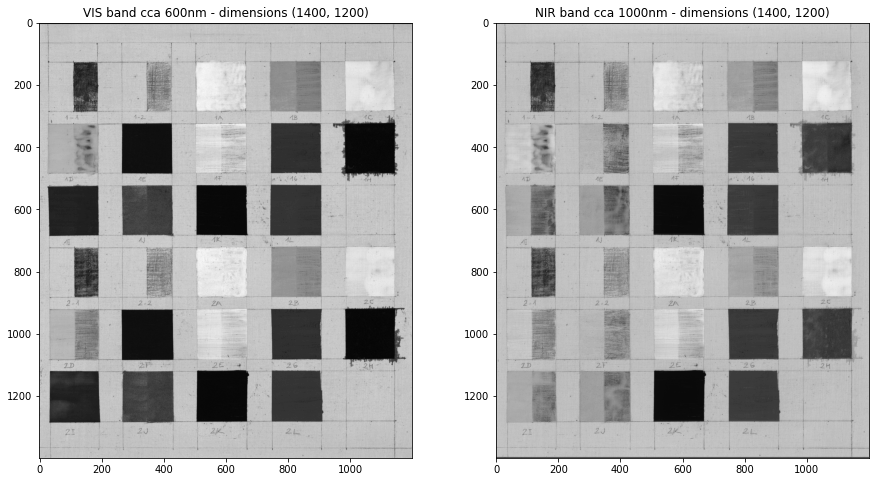

In [5]:
plt.figure(figsize=(15,8))
ax = plt.subplot(1,2,1)
ax.imshow(vis, cmap="gray")
ax.set_title(f"VIS band cca 600nm - dimensions {vis.shape}")
ax = plt.subplot(1,2,2)
ax.imshow(nir, cmap="gray")
ax.set_title(f"NIR band cca 1000nm - dimensions {nir.shape}")
plt.show()

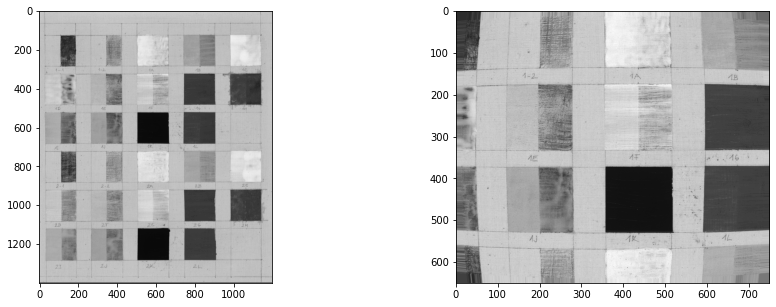

In [6]:
# Configuration of input transformation
center = [0, 0]
k = [0.02, 0.01, 0.001]
T = Transformation.build_radial(center[0], center[1], k[0], k[1], k[2])
nir_t = T.apply_tform(nir[150:800,150:900])
plt.figure(figsize=(15,5))
ax = plt.subplot(1,2,1)
ax.imshow(nir, cmap="gray")
ax = plt.subplot(1,2,2)
ax.imshow(nir_t, cmap="gray")
plt.show()

In [7]:
with open("input/radial-config.yaml", "rt", encoding='utf-8') as config_file:
    config = yaml.load(config_file, Loader=yaml.Loader)
    cfgtools.init_config(config)
cfgtools.get_config()["crop"] = {
    "left_top": {
        "x": 0,
        "y": 0,
    },
    "size": {
        "height": nir_t[0],
        "width": nir_t[1]
    }
}
ii.init(nir_t.shape[0], nir_t.shape[1])

Config integrity: OK


In [8]:
train_set_size = 80000
reg_layer_data = vis[150:800,150:900].reshape(650,750,1)
indexes = pixels_for_training_radial(train_set_size, nir_t.shape)
indexes_T = np.round(T.apply_distortion(indexes, 750, 650)).astype(int)
outs_t = np.array([nir[indexes_T[i, 0], indexes_T[i, 1]] for i in range(indexes_T.shape[0])])
outputs = np.array([nir_t[indexes[i,0], indexes[i,1]] for i in range(indexes.shape[0])])
inputs = img2coords(reg_layer_data.shape)

In [9]:
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [10]:
input_layer = tf.keras.layers.Input(shape=(indexes.shape[1],),
                                        dtype=tf.float64, name='InputLayer')

In [11]:
radial_distortion_layer = RDCompleteLayer(0,0, 750, 650, name='RDistortionLayer')(input_layer)

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [12]:
layer = Idx2PixelLayer(visible=np.array(nir[150:800,150:900]).reshape(650,750,1), name='Idx2PixelLayer')(radial_distortion_layer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [13]:
output_layer = tf.keras.layers.ReLU(max_value=255, name='Output', trainable=False)(layer)

In [14]:
model = tf.keras.models.Model(inputs=input_layer, outputs=output_layer)
m2 = tf.keras.models.Model(inputs=input_layer, outputs=radial_distortion_layer)
mcp_save = tf.keras.callbacks.ModelCheckpoint(
            filepath='best_model.tmp.h5',
            save_weights_only=True,
            monitor='val_acc',
            mode='min',
            save_best_only=True)

model.layers[1].set_weights([np.array([k[0]]), np.array([k[1]]), np.array([k[2]])])

m2.compile(loss='mean_squared_error',
  optimizer='Adam',
  metrics=['mean_squared_error']
  )
model.compile(loss='mean_squared_error',
  optimizer='Adam',
  metrics=['mean_squared_error']
  )

In [15]:
outs = model.predict(inputs)
train_outs = np.array([outs.reshape(650,750)[indexes[i,0], indexes[i, 1]] for i in range(indexes_T.shape[0])])

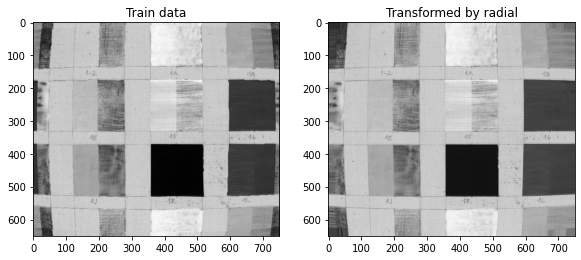

In [16]:
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.imshow(outs.reshape(650,750), cmap="gray")
ax.set_title("Train data")
ax = plt.subplot(1,3,2)
ax.imshow(nir_t, cmap="gray")
ax.set_title("Transformed by radial")
plt.show()

In [17]:
# # Fill ground truth and check response
# model.layers[1].set_weights([np.array([0.02]), np.array([0.01]), np.array([0])])
# m2.compile(loss='mean_squared_error',
#   optimizer='Adam',
#   metrics=['mean_squared_error']
#   )
# model.compile(loss='mean_squared_error',
#   optimizer='Adam',
#   metrics=['mean_squared_error']
#   )

In [18]:
# Look into layer parameters
model.layers[1].get_weights()

[array([0.02]), array([0.01]), array([0.001])]

In [24]:
#model.layers[1].set_weights([np.array([0]), np.array([0]), np.array([0])])

class MyCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        lr = self.model.optimizer.lr
        # If you want to apply decay.
        decay = self.model.optimizer.decay
        iterations = self.model.optimizer.iterations
        lr_with_decay = lr / (1. + decay * tf.keras.backend.cast(iterations, tf.keras.backend.dtype(decay)))
        print(f"\n{tf.keras.backend.eval(lr_with_decay)}")
        
optimizer = tf.keras.optimizers.Adam(learning_rate=7.7e-5, decay=0.2, amsgrad=True)

m2.compile(loss='mean_squared_error',
  optimizer='Adam',
  metrics=['mean_squared_error']
  )
model.compile(loss='mean_squared_error',
  optimizer=optimizer,
  metrics=['mean_squared_error']
  )

# The model fit

In [25]:
history = model.fit(indexes,
                    train_outs,
                    epochs=20,
                    validation_split=0.2,
                    batch_size=2048,
                    verbose=0,
                    callbacks=[mcp_save, tensorboard_callback, MyCallback()]
                    )


1.0405405191704631e-05

5.579709977610037e-06

3.8118807879072847e-06

2.8947367809450952e-06

2.3333332137553953e-06

1.954314484464703e-06

1.6812226704132627e-06

1.475095700698148e-06

1.3139930388206267e-06

1.1846153711303486e-06

1.0784312962641707e-06

9.897171366901603e-07

9.144892487711331e-07

8.498896022501867e-07

7.938144221952825e-07

7.446807899214036e-07

7.01274984749034e-07

6.626505637541413e-07

6.280587285800721e-07

5.968992127236561e-07


In [23]:
model.load_weights('best_model.tmp.h5')
print(model.layers[1].get_weights())
model.compile(loss='mean_squared_error',
  optimizer='Adam',
  metrics=['mean_squared_error']
)

[array([0.02012155]), array([0.0095502]), array([0.00139113])]


In [22]:
model.layers[1].get_weights()

[array([0.01859565]), array([0.01179174]), array([0.00076789])]

In [ ]:
outs = model.predict(inputs)
plt.figure(figsize=(15,5))
ax = plt.subplot(1,3,1)
ax.imshow(outs.reshape(650,750), cmap="gray")
ax = plt.subplot(1,3,2)
ax.imshow(nir_t, cmap="gray")
ax = plt.subplot(1,3,3)
ax.imshow(nir_t-outs.reshape(650,750), cmap="gray")
plt.show()

In [187]:
model.compile(loss='mean_squared_error',
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, decay=0.99),
  metrics=['mean_squared_error']
)
history = model.fit(indexes,
                    train_outs,
                    epochs=50,
                    validation_split=0.2,
                    verbose=1,
                    batch_size=2048,
                    callbacks=[mcp_save]
                    )

Train on 64000 samples, validate on 16000 samples
Epoch 1/50
64000/64000 [==============================] - ETA: 26s - loss: 49.6885 - mean_squared_error: 49.688 - ETA: 2s - loss: 2312.8070 - mean_squared_error: 2312.80 - ETA: 1s - loss: 1707.4198 - mean_squared_error: 1707.42 - ETA: 0s - loss: 1266.9541 - mean_squared_error: 1266.95 - ETA: 0s - loss: 1050.9558 - mean_squared_error: 1050.95 - 2s 37us/sample - loss: 957.0647 - mean_squared_error: 957.0648 - val_loss: 89.5893 - val_mean_squared_error: 89.5893
Epoch 2/50
64000/64000 [==============================] - ETA: 0s - loss: 77.6170 - mean_squared_error: 77.61 - ETA: 0s - loss: 183.1291 - mean_squared_error: 183.12 - ETA: 0s - loss: 187.8288 - mean_squared_error: 187.82 - ETA: 0s - loss: 171.0575 - mean_squared_error: 171.05 - ETA: 0s - loss: 174.8079 - mean_squared_error: 174.80 - ETA: 0s - loss: 171.6476 - mean_squared_error: 171.64 - ETA: 0s - loss: 165.6229 - mean_squared_error: 165.62 - ETA: 0s - loss: 162.5693 - mean_squared

In [188]:
model.layers[1].get_weights()

[array([0.01975025], dtype=float32), array([0.01010852], dtype=float32), array([0.0011181], dtype=float32)]

In [ ]:
np.array([nir_t[indexes[i,0], indexes[i,1]] for i in range(indexes.shape[0])])

### Cleanup the training output

In [ ]:
model.layers[1].set_weights([np.array([0]), np.array([0]), np.array([0])])

### Edge detection and training on edge pixels

In [ ]:
plt.imshow(cv2.Canny(nir[150:800,150:900].astype(np.uint8), 0, 40))
plt.title("Detected edges - example")
plt.show()

In [189]:
edges = cv2.Canny(nir[150:800,150:900].astype(np.uint8), 128, 128)
eins = np.where(edges != 0)
xx = eins[0][np.logical_and(
    np.logical_and(eins[0] < 750, eins[0] >= 0),
    np.logical_and(eins[1] < 650, eins[1] >= 0)
)]
yy = eins[1][np.logical_and(
    np.logical_and(eins[0] < 750, eins[0] >= 0),
    np.logical_and(eins[1] < 650, eins[1] >= 0)
)]

In [200]:
#eins_global = T.apply_distortion(np.stack([xx, yy], axis=1))
#np.array([outs.reshape(650,750)[indexes[i,0], indexes[i, 1]] for i in range(indexes_T.shape[0])])
eous = np.array([outs.reshape(650,750)[x, y] for x,y in zip(xx,yy)])

In [191]:
plt.figure(figsize=(15,7))
ax = plt.subplot(1,2,1)
ax.imshow(nir_t, cmap="gray")
ax.plot(yy, xx, marker="+", alpha=0.1)
ax.set_title("Edge points projected to output image")

ax = plt.subplot(1,2,2)
ax.imshow(T.apply_tform(nir[150:800, 150:900]), cmap="gray")
ax.plot(eins_global[:,1], eins_global[:,0], alpha=0.4, marker="+", linestyle = 'None')
ax.set_title("Transformed coordinates of edge pixels projected on transformed image")
plt.show()

In [202]:
model.compile(loss='mean_squared_error',
  optimizer=tf.keras.optimizers.SGD(learning_rate=0.0001, decay=0.99),
  metrics=['mean_squared_error']
)
history = model.fit(np.stack([xx, yy], axis=1),
                    eous.astype(np.float64),
                    epochs=300,
                    validation_split=0.2,
                    verbose=1,
                    batch_size=2048,
                    callbacks=[mcp_save]
                    )

Train on 17744 samples, validate on 4436 samples
Epoch 1/300
17744/17744 [==============================] - ETA: 5s - loss: 72.7599 - mean_squared_error: 72.75 - 2s 114us/sample - loss: 2380.7505 - mean_squared_error: 2380.7507 - val_loss: 4250.0218 - val_mean_squared_error: 4250.0215
Epoch 2/300
17744/17744 [==============================] - ETA: 0s - loss: 2714.1152 - mean_squared_error: 2714.11 - ETA: 0s - loss: 2622.5520 - mean_squared_error: 2622.55 - 0s 8us/sample - loss: 2628.5323 - mean_squared_error: 2628.5320 - val_loss: 3312.7892 - val_mean_squared_error: 3312.7893
Epoch 3/300
17744/17744 [==============================] - ETA: 0s - loss: 2474.0671 - mean_squared_error: 2474.06 - ETA: 0s - loss: 2437.7035 - mean_squared_error: 2437.70 - 0s 8us/sample - loss: 2482.0127 - mean_squared_error: 2482.0129 - val_loss: 2522.9065 - val_mean_squared_error: 2522.9065
Epoch 4/300
17744/17744 [==============================] - ETA: 0s - loss: 2338.5093 - mean_squared_error: 2338.50 - 0s 

In [203]:
model.layers[1].get_weights()

[array([0.02023616], dtype=float32), array([0.00928171], dtype=float32), array([0.00149412], dtype=float32)]

In [204]:
trained = model.predict(inputs)

In [209]:
plt.hist((outs-trained), bins=np.arange(-1,1,0.01))
plt.show()

In [21]:
%tensorboard --logdir logs/fit

Reusing TensorBoard on port 6006 (pid 67255), started 1:01:17 ago. (Use '!kill 67255' to kill it.)